# Electricity Demand Forecasting

Time Series Modeling
In this project I am exploring time series modeling for Electricity Demand Forecasting for the state of California.

This notebook contains the SARIMAX modeling for the daily demand aggregated data.  The data was cleaned and aggregated in the EF_EDA_CleanSplitAgg notebook.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Module Import](#import)<br>
2. [Data Import](#read_data)<br>
    2A. [Clean Data](#clean_data)<br>
    2B. [Extend Data](#extend_dow)<br>
    2C. [Data Split](#data_split)<br>
3. [Helper Functions](#helper)<br>
4. [Data Analysis](#analysis)<br>
    4A. [Stationarity Testing](#stationarity)<br>
    4B. [Autocorrelation](#autocorr)<br>
    4C. [Seasonal Decomposition](#seasonal_decomp)<br>
5. [Modeling](#modeling)<br>
    5A. [SARIMAX Without Exogenous Data](#SARI_NoX)<br>
    5A.1 [SARIMAX Without Exogenous Data Fit Plot 1](#plot-SARI_fit_zoom)<br>
    5A.2 [SARIMAX Without Exogenous Data Fit Plot 2](#plot-SARI_fit_wide)<br>
    5A.3 [SARIMAX Without Exogeneous Data - Forecast](#forecast-SARI_nox)<br>

    5B. [SARIMAX With Exogeneous Data](#model-SARIMAX-wexog)<br>
    5B.1 [SARIMAX With Exogeneous Data - Fit Plot Close](#plot-SARI_exog_fit_zoom)<br>
    5B.2 [SARIMAX With Exogeneous Data - Fit Plot 3 Month](#plot-SARI_exof_fit_wide)<br>
    5B.3 [SARIMAX With Exogeneous Data - Forecast](#forecast-SARI_exog)<br>

    5C. [SARIMAX With Extended Exogeneous Data](#model-SARI-xexog)<br>
    5C.1 [SARIMAX With Extended Exogeneous Data - Fit Plot Close](#plot-SARI_xexog_fit_zoom)<br>
    5C.2 [SARIMAX With Extended Exogeneous Data - Fit Plot 3 Month](#plot-SARI_xexof_fit_wide)<br>
    5C.3 [SARIMAX With Extended Exogeneous Data - Forecast](#forecast-SARI_xexog)<br>


----

----
### <a id='import'> 1. Module Import </a>

Import the modules used in this notebook.

----

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict

import pickle
import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.statespace.mlemodel

In [2]:
# Eleminate some of the warning messages.
warnings.filterwarnings('ignore')

----
### 2. Data Import <a id='read_data'></a>

Read the data file created by the notebook EF_EDA_CleanSplitAgg.

----


In [3]:
data_file = '../data/big_demand_temp_train_by_day.csv'

In [4]:
full_df = pd.read_csv(data_file, index_col=0)

#### 2A. Clean Data<a id='clean_data'></a>

Most of the data cleaning was done in the script file 
and the Clean-Split-Agg notebook. The next few cells just change 
the data type for the index and extend the exogenous 
variables to include the day of the week.


In [5]:
# Convert the time string to a datetime object
full_df.index = pd.DatetimeIndex(full_df.index)


----

#### 2B. Extend Data<a id='extend_dow'></a>

----


In [6]:
days = full_df['DOW']
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names

----

#### 2C. Data Split <a id='data_split'></a>

Split the data into a primary training dataset and
three testing blocks for walk-forward validation.

----


In [7]:
# Split the data into training and test sections
data_len = new_df.shape[0]

In [8]:
# Split the data frame into two parts
train_len = int(0.7 * data_len)
window_len = int(0.1 * data_len)

In [9]:
# Make the primary train/validation split
X_train = new_df.iloc[:train_len, :]

# Make intermediate trail windows for walk forward validation
X_walk1 = new_df.iloc[train_len:train_len+window_len, :]
X_walk2 = new_df.iloc[train_len+window_len:train_len+2*window_len, :]
X_walk3 = new_df.iloc[train_len+2*window_len:train_len+3*window_len, :]

In [10]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 958 entries, 2015-07-01 to 2018-02-12
Data columns (total 16 columns):
day_demand    958 non-null float64
CA_pop        958 non-null float64
la_high       958 non-null float64
sd_high       958 non-null float64
sj_high       958 non-null float64
sf_high       958 non-null float64
sac_high      958 non-null float64
f_high        958 non-null float64
DOW           958 non-null float64
Mon           958 non-null uint8
Tue           958 non-null uint8
Wed           958 non-null uint8
Thur          958 non-null uint8
Fri           958 non-null uint8
Sat           958 non-null uint8
Sun           958 non-null uint8
dtypes: float64(9), uint8(7)
memory usage: 81.4 KB


----

### 3. Helper Functions <a id='helper'></a>

This funtion tests the stationarity of the data set and generates a plot of the test data.

The function was originally published as part of the Blog post

    https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba

----


In [11]:

def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    '''
        Function: test_stationarity
            This fuction runs the Dickey-Fuller test for stationarity on the timeseries parameter.
        Parameters:
            timeseries - data for the dependent variable in the time series.
            window - size of the window used for statistical analysis
            cutoff - limit for the p-value from the Dickey-Fuller test to categorize data as stationary or not. 
        Return:
            None
    '''

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )

    #Put the results in a Pandas series
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    # Print the individual results
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    # Test the p-value of 5% critical value
    pvalue = dftest[1]

    # If we're below the cutoff then the data is probably stationary
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [12]:
def order_sweep(model, arima_order_list, seasonal_order_list, endo_data, exo_data=None) :
    '''
        Function: order_sweep
            This fuction conducts a series of SARIMAX model fits for different sets of
            order parameter configurations.  The SARIMAX model uses two different sets of
            parameters for model fit: arima order (p-d-q) and seasonal order (P-D-Q-S).
            The arima parameters are:
                p - number of trailing autoregressive steps to use
                d - number of differencing (discrete time differentiation) steps to use to make the data stationary.
                q - number of trailing error values to use in the moving average component of the model.
            The seasonl parameters are:
                P - number of trailing autoregressive seasonal components to include
                D - number of seasonal differencing steps to use
                Q - number of trailing seasonal errors to use in the moving average component
                s - number of time steps in the the 'season'
        
        Parameters:
            model - function that will be used for model definition and fit.
            arima_order_list - list of tuples containing the arima order parameters to test.
            seasonal_order_list - list of tuples containing the seasonal parameters to test.
            endo_data - endogenous time series data we are trying to model
            exo_data - exogenous data that supports the model development

        Return:
            aic_dict - Dictionary containing the parameters used for a model fit and the aic, bic and mse scores for the fit.

    '''
    aic_dict = defaultdict(dict)
    i=0
    for order in arima_order_list :
        for seasonal in seasonal_order_list :
            if exo_data is not None :
                mod = model(endo_data, order=order, seasonal_order=seasonal, exog=exo_data)
            else :
                mod = model(endo_data, order=order, seasonal_order=seasonal)
                
            try :
                res = mod.fit()
                aic_dict[i] = {'order': order, 'seasonal order': seasonal, 
                    'aic': res.aic, 'bic':res.bic, 'mse': res.mse}
            except :
                continue
                
            i += 1
    return aic_dict

In [13]:
def top_results(result_dict, test_key, count) :
    '''
        Function top_results
            Return the best results from the results dictionary based on the indicated score

        Parameters:
            result_dict - dictionary containing the results from the order_sweep test
            test_key - string containing the key used to evaluate the results.  Can be 'aic', 'bic', or 'mse'.
            count - number of results to return

        Return:
            sorted list of top results in order.  For each of these metrics lower values are better.

    '''

    # Create lists for storing the results
    top_result = [1000000]*count
    order_list = [0]*count
    ret_results = []

    # for each set of results
    for i in result_dict.keys() :
        # Check if the current score is lower than the largest in the current list
        if result_dict[i][test_key] < max(top_result) :
            # If we have an improvement then replace the largest value with the current results
            top_result[top_result.index(max(top_result))] = result_dict[i][test_key]
            # Save the index of the results
            order_list[top_result.index(max(top_result))] = i

    # Create a list of the top results from the saved index values        
    for idx in order_list :
        ret_results.append(result_dict[idx])

    # Sort and return the list of values based on the specified key    
    return sorted(ret_results, key=lambda x : x[test_key])
        

----


### 4. Data Analysis <a id='analysis'></a>

Run through a quick analysis of the data, testing for stationarity and examining the auto regressive characteristics of the data.


___

----

#### 4A. Stationarity Testing <a id='stationarity'></a>

Use the Dickey-Fuller stationarity test to test the input data.  Note that in order
to achieve stationarity I had to take the log of the demand data.

----

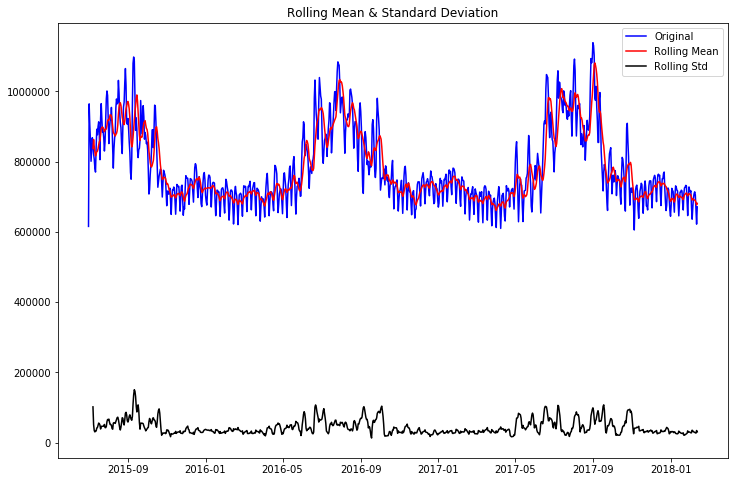

Results of Dickey-Fuller Test:
p-value = 0.1663. The series is likely non-stationary.
Test Statistic                  -2.317736
p-value                          0.166311
#Lags Used                      20.000000
Number of Observations Used    937.000000
Critical Value (1%)             -3.437348
Critical Value (5%)             -2.864630
Critical Value (10%)            -2.568415
dtype: float64


In [14]:
test_stationarity(X_train.day_demand, window=8)

Daily data is not stationary.  Try a simple difference to see if we can get a stationary result

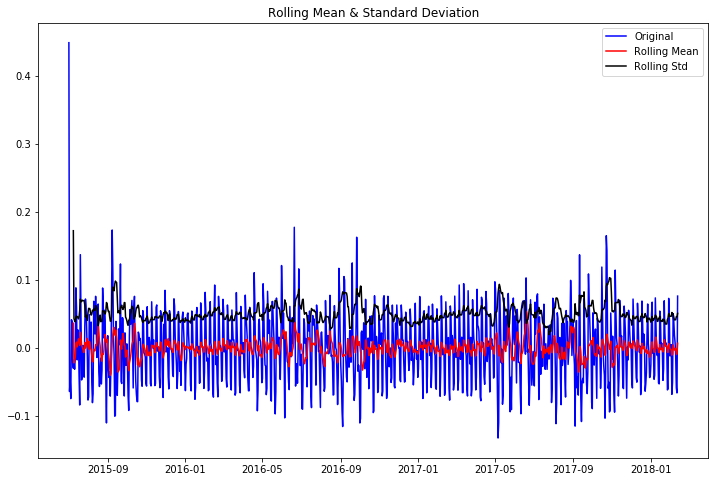

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.805599e+00
p-value                        7.296085e-12
#Lags Used                     2.000000e+01
Number of Observations Used    9.360000e+02
Critical Value (1%)           -3.437356e+00
Critical Value (5%)           -2.864633e+00
Critical Value (10%)          -2.568417e+00
dtype: float64


In [15]:
diff_demand_day = X_train.day_demand.diff()[1:]
log_demand = np.log(X_train.day_demand)

test_stationarity(log_demand.diff()[1:], window=8)

Need to take the log of the daily demand to get a stationary time series

----

#### 4B. Autocorrelation <a id='autocorr'></a>

Use autocorrelation to get an idea of the order parameters we may want to test in our model.

-----


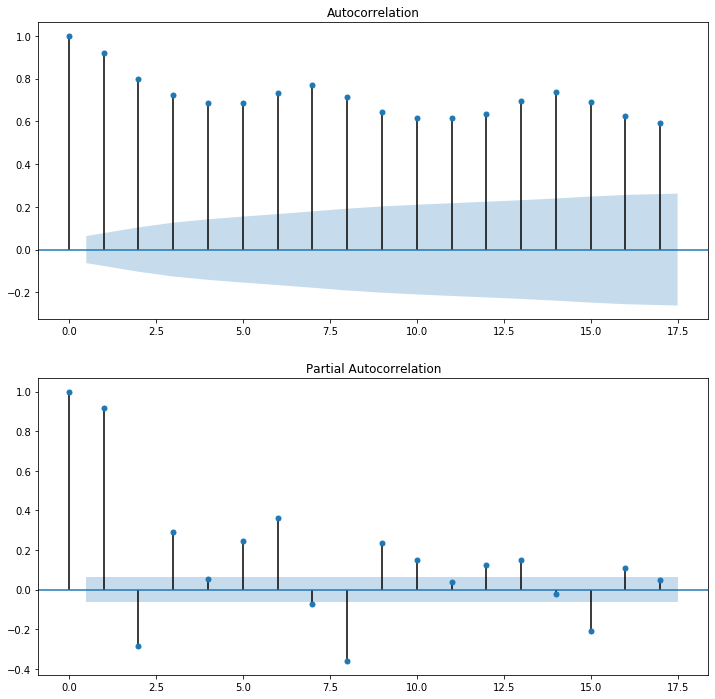

In [16]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_demand, lags=7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_demand, lags=7+10, ax=ax2)# , lags=40

----

#### <a id='seasonal_decomp'>4C. Seasonal Decomposition </a>

----

In [17]:
# Do seasonal decopostion on the weekly periodic features
decomp_data = seasonal_decompose(log_demand, period=7, model='additive')

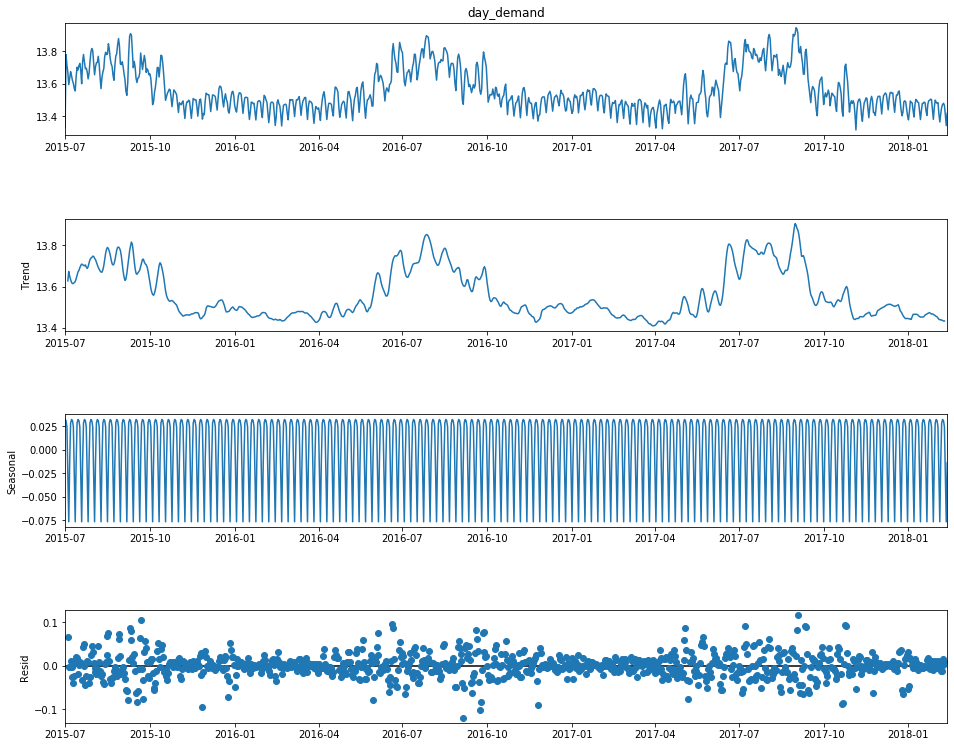

In [18]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

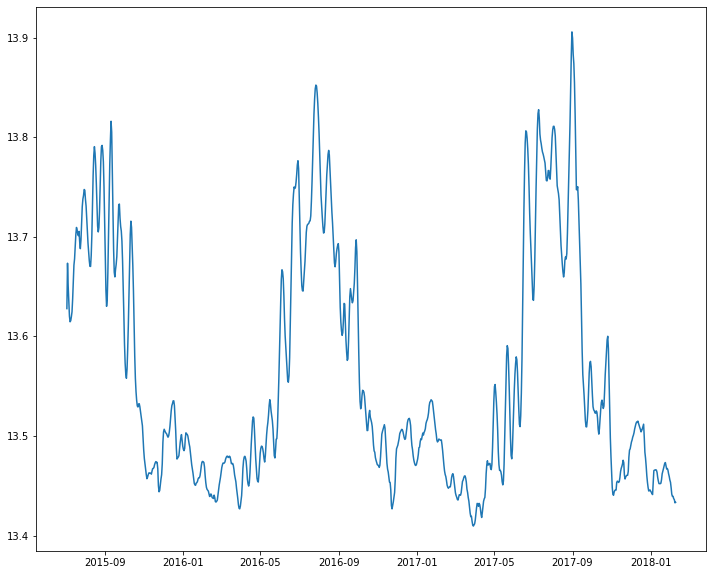

In [19]:
# Plot a closeup of the seasonal component
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.trend[:10000])

In [20]:
# Add Log_demand to the dataframe
X_train['log_demand'] = np.log(X_train['day_demand'])

----

### 5. <a id='modeling'>Modeling </a>

In the following cells I do a number of model fits to find the 'best' parameters to include in the final model.

----

#### 5A. <a id='SARI_NoX'>SARIMAX Without Exogeneous Data </a>

In [21]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1),
             (5,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7),
                (3,1,1, 7),
                (4,1,1, 7),
                (5,1,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  endo_data=X_train['log_demand'])


In [22]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)


{'order': (4, 1, 1), 'seasonal order': (3, 1, 1, 7), 'aic': -3879.672309544705, 'bic': -3831.1076896987593, 'mse': 0.23359374277443584}
{'order': (5, 0, 1), 'seasonal order': (3, 1, 1, 7), 'aic': -3871.630738127188, 'bic': -3818.198083439189, 'mse': 1.3584055909347175}
{'order': (3, 1, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -3869.5589027934598, 'bic': -3830.707206916703, 'mse': 0.23361580138624197}
{'order': (5, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -3868.0793645154413, 'bic': -3814.577527209459, 'mse': 0.18662793285016313}
{'order': (3, 0, 0), 'seasonal order': (5, 1, 0, 7), 'aic': -3863.9957825311976, 'bic': -3820.278155968289, 'mse': 1.3584103709500897}


In [23]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)


{'order': (5, 1, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -3891.753153732741, 'bic': -3843.188533886795, 'mse': 0.23358371279632165}
{'order': (4, 1, 1), 'seasonal order': (3, 1, 1, 7), 'aic': -3879.672309544705, 'bic': -3831.1076896987593, 'mse': 0.23359374277443584}
{'order': (4, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -3873.4327124992074, 'bic': -3824.794678584678, 'mse': 0.18664678920673164}
{'order': (5, 0, 0), 'seasonal order': (3, 1, 1, 7), 'aic': -3868.8757946902897, 'bic': -3820.3006540648357, 'mse': 1.3584014979757917}
{'order': (3, 0, 0), 'seasonal order': (5, 1, 0, 7), 'aic': -3863.9957825311976, 'bic': -3820.278155968289, 'mse': 1.3584103709500897}


In [24]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)


{'order': (5, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -3849.1897614374157, 'bic': -3800.5517275228863, 'mse': 0.18664365169974423}
{'order': (4, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -3861.6818889477963, 'bic': -3817.9076584247196, 'mse': 0.18665181057068492}
{'order': (4, 1, 1), 'seasonal order': (3, 0, 1, 7), 'aic': -3841.2432465945603, 'bic': -3792.605212680031, 'mse': 0.186661895626601}
{'order': (4, 1, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -3853.7101968786756, 'bic': -3800.208359572693, 'mse': 0.18668339014832358}
{'order': (4, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -3836.4274325526267, 'bic': -3787.7893986380973, 'mse': 0.1867891698302533}


In [25]:
# Now choose the results that seem to work the best above and fit the model
best_order1 = (4, 1, 1)
best_seasonal_order1 = (5, 0, 0, 7)
model1 = SARIMAX(X_train['log_demand'], order=best_order1, seasonal_order=best_seasonal_order1)
res1 = model1.fit()

In [26]:
print(res1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         log_demand   No. Observations:                  958
Model:             SARIMAX(4, 1, 1)x(5, 0, [], 7)   Log Likelihood                1925.632
Date:                            Tue, 07 Apr 2020   AIC                          -3829.264
Time:                                    08:45:54   BIC                          -3775.762
Sample:                                07-01-2015   HQIC                         -3808.886
                                     - 02-12-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2482      0.146      1.702      0.089      -0.038       0.534
ar.L2         -0.1597      0.078   

In [27]:
res1.aic, res1.bic, res1.mse

(-3829.2635820891223, -3775.76174478314, 0.1867928769818713)

In [28]:
# Save the trained model
filename = 'SARIMAX_wo_exog_day.sav'
pickle.dump(model1, open(filename, 'wb'))

In [29]:
demand_hat = np.exp(res1.fittedvalues)

----

##### 5A.1 SARIMAX Without Exogeneous Data - Fit Plot Close <a id='plot-SARI_fit_zoom'></a>

----


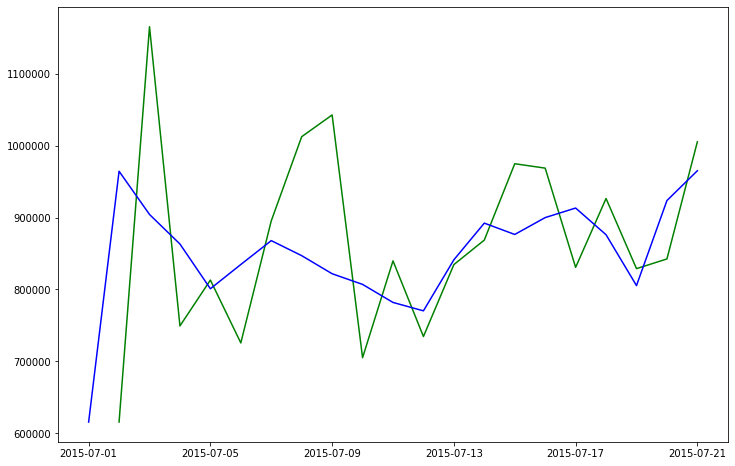

In [30]:
fig = plt.figure(figsize=[12, 8])
close_window = 3*7

plt.plot(demand_hat[1:close_window], label='Predicted', c='g')
plt.plot(X_train.index[:close_window], X_train['day_demand'].values[:close_window], \
         c='b', label='Actual (train)')

----

##### <a id='plot-SARI_fit_wide'>5A.2 SARIMAX Without Exogeneous Data - Fit Plot 3 Months  </a>

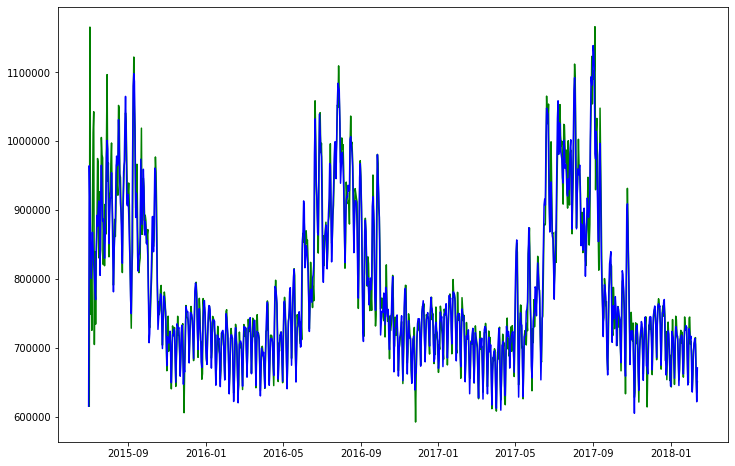

In [31]:
fig = plt.figure(figsize=[12, 8])

plt.plot(demand_hat[1:1000], c='g')
plt.plot(X_train.index[0:1000], X_train['day_demand'].values[0:1000], c='b')

----

##### 5A.3 SARIMAX Without Exogeneous Data - Forecast <a id='forecast-SARI_nox'></a>

----

In [32]:
predict_steps = 7*3
predict1 = res1.get_forecast(predict_steps)
pred_ci1 = np.exp(predict1.conf_int(alpha=0.5))
pred_vals1 = np.exp(predict1.predicted_mean)

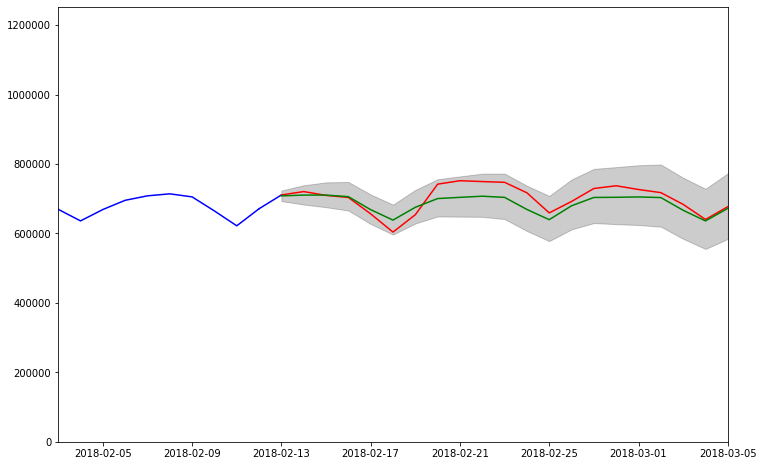

In [33]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci1.iloc[:, 0].values
high_values = pred_ci1.iloc[:, 1].values
pred_times1 = pred_ci1.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times1))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times1, pred_vals1.values, c='g')


plt.fill_between(pred_times1, low_values, high_values, color='k', alpha=0.2)

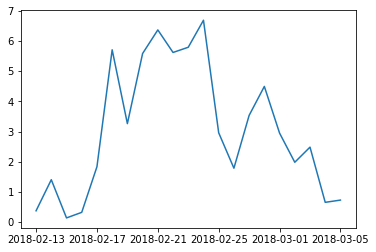

In [34]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals1.values[x]) for x in range(len(pred_vals1))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times1, percent_error)
#plt.ylim(0, 7000)

In [35]:
mape1 = np.mean(percent_error[:21])
print(mape1)

3.0799381063239033


#### <a id='model-SARIMAX-wexog'>5B. SARIMAX With Exogeneous Data </a>

In [36]:
# The trailing columns are city temperatures and state population
important_cities = ['la_high',  'f_high']

In [37]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[important_cities])

#res1 = seasonal_model1.fit()

In [38]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)


{'order': (3, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -3940.1203188633203, 'bic': -3881.8301501127758, 'mse': 1.3013560158411521}
{'order': (5, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -3935.7552434155305, 'bic': -3867.750046539895, 'mse': 1.301061117173579}
{'order': (4, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -3935.367903009391, 'bic': -3872.220220196301, 'mse': 1.302512733686817}
{'order': (3, 0, 1), 'seasonal order': (4, 1, 0, 7), 'aic': -3930.934963332012, 'bic': -3877.502308644013, 'mse': 1.302537677269215}
{'order': (5, 0, 0), 'seasonal order': (4, 1, 0, 7), 'aic': -3920.0184061391537, 'bic': -3861.728237388609, 'mse': 1.3014512439060248}


In [39]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)


{'order': (3, 0, 1), 'seasonal order': (4, 1, 0, 7), 'aic': -3930.934963332012, 'bic': -3877.502308644013, 'mse': 1.302537677269215}
{'order': (4, 0, 1), 'seasonal order': (5, 1, 0, 7), 'aic': -3935.367903009391, 'bic': -3872.220220196301, 'mse': 1.302512733686817}
{'order': (4, 0, 1), 'seasonal order': (4, 1, 0, 7), 'aic': -3927.4917829718024, 'bic': -3869.201614221258, 'mse': 1.3010375937777028}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 0, 7), 'aic': -3929.6942078917345, 'bic': -3866.464763802846, 'mse': 0.17887965183958993}
{'order': (5, 0, 0), 'seasonal order': (4, 1, 0, 7), 'aic': -3920.0184061391537, 'bic': -3861.728237388609, 'mse': 1.3014512439060248}


In [40]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)
    

{'order': (3, 0, 1), 'seasonal order': (5, 0, 0, 7), 'aic': -3689.950684565355, 'bic': -3631.5725112297046, 'mse': 0.17693697479259896}
{'order': (3, 0, 1), 'seasonal order': (3, 0, 1, 7), 'aic': -3663.4242158110083, 'bic': -3609.910890253329, 'mse': 0.17713710206642544}
{'order': (5, 0, 1), 'seasonal order': (3, 0, 0, 7), 'aic': -3645.504359263674, 'bic': -3587.1261859280235, 'mse': 0.17794699841443112}
{'order': (5, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -3856.853103025293, 'bic': -3798.4874623278574, 'mse': 0.1782940560737388}
{'order': (5, 1, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -3837.8621044044708, 'bic': -3784.3602670984883, 'mse': 0.1784793335753878}


In [41]:
# Now choose the results that seem to work the best above and fit the model
best_order2 = (3, 0, 1)
best_seasonal_order2 = (3, 0, 0, 7)
model2 = SARIMAX(X_train['log_demand'], order=best_order2, seasonal_order=best_seasonal_order2, exog=X_train[important_cities])
res2 = model2.fit()

In [42]:
print(res2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         log_demand   No. Observations:                  958
Model:             SARIMAX(3, 0, 1)x(3, 0, [], 7)   Log Likelihood                1841.964
Date:                            Tue, 07 Apr 2020   AIC                          -3663.929
Time:                                    09:41:37   BIC                          -3615.280
Sample:                                07-01-2015   HQIC                         -3645.400
                                     - 02-12-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
la_high        0.0010      0.000      4.503      0.000       0.001       0.001
f_high         0.0016      0.000   

In [43]:
# Save the trained model
filename = 'SARIMAX_w_exog_day.sav'
pickle.dump(model2, open(filename, 'wb'))

In [44]:
res2.aic

-3663.9285430416285

In [45]:
demand_hat2 = np.exp(res2.fittedvalues)

----
##### 5B.1 <a id='plot-SARI_exog_fit_zoom'>SARIMAX With Exogeneous Data - Fit Plot Close </a>
----

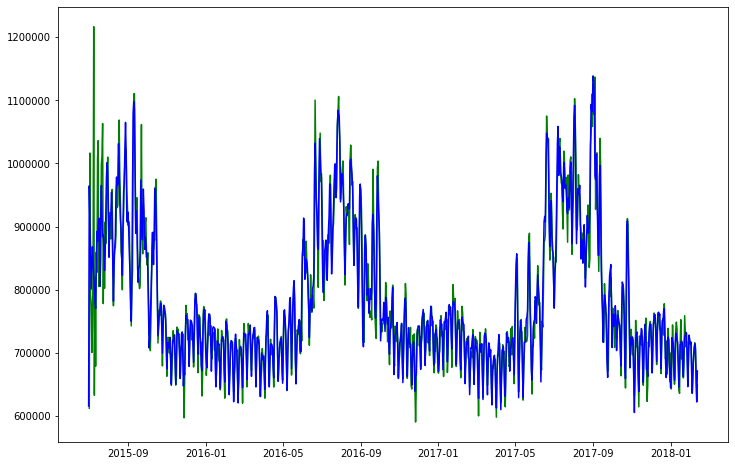

In [46]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(25000, 55000)

plt.plot(demand_hat2[1:], c='g')
plt.plot(X_train.index, X_train['day_demand'].values, c='b')

----

##### <a id='plot-SARI_exof_fit_wide'>5B.2 SARIMAX With Exogeneous Data - Fit Plot 3 Month </a>

----

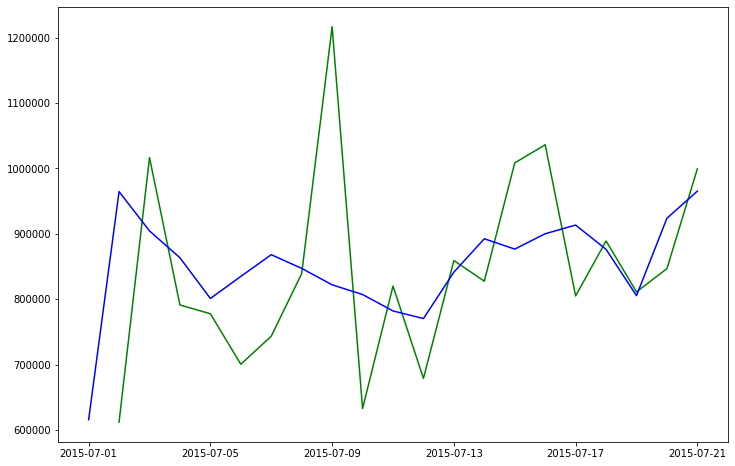

In [47]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat2[1:21], label='Prediction', c='g')
actual = X_train['day_demand'].values
plt.plot(X_train.index[:21], X_train['day_demand'].values[:21], c='b', label='Actual')

----
##### <a id='forecast-SARI_exog'>5B.3 SARIMAX With Exogeneous Data - Forecast  </a>
----

In [48]:
predict_steps = 7*4
predict2 = res2.get_forecast(predict_steps, 
                exog=X_walk1[important_cities].values[:predict_steps, :])
pred_ci2 = np.exp(predict2.conf_int(alpha=0.5))
pred_vals2 = np.exp(predict2.predicted_mean)

In [49]:
aic2 = res2.aic

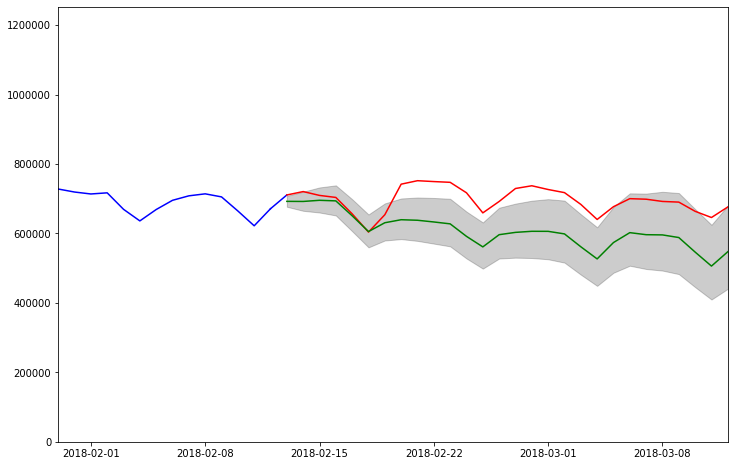

In [50]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci2.iloc[:, 0].values
high_values = pred_ci2.iloc[:, 1].values
pred_times2 = pred_ci2.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times2))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times2, pred_vals2.values, c='g')


plt.fill_between(pred_times2, low_values, high_values, color='k', alpha=0.2)

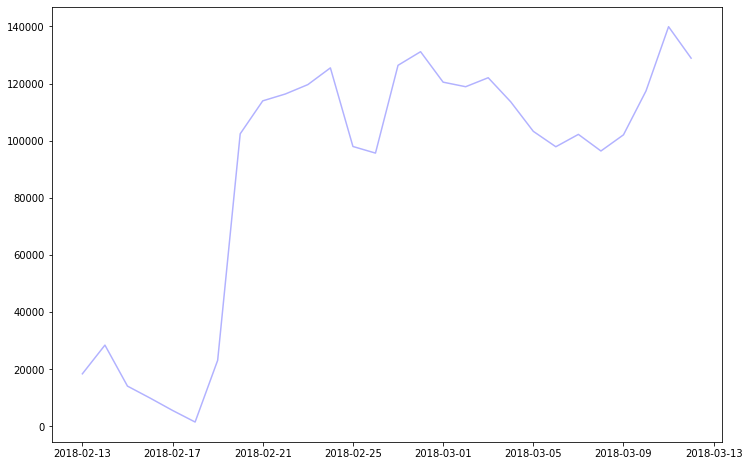

In [51]:
fig = plt.figure(figsize=[12, 8])
residuals2 = [abs(X_walk1['day_demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
plt.plot(pred_times2, residuals2, c='b', alpha=0.3)
#plt.ylim(0, 10000)

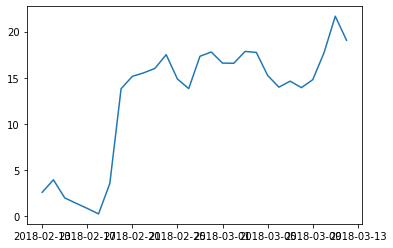

In [52]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals2.values[x]) for x in range(len(pred_vals2))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times2, percent_error)
#plt.ylim(0, 7000)

In [53]:
mape2 = np.mean(percent_error[:21])
print(mape2)

11.44315795408848


----
#### <a id='model-SARI-xexog'>5C. SARIMAX With Extended Exogeneous Data </a>
----

In [54]:
# Use all the dummies for the day of the week but don't use the DOW column
all_exog_columns = X_train.columns[1:-1]

In [55]:
# Define the model for SARIMAX just using the demand data
order_list =[(3,0,0),
             (4,0,0),
             (5,0,0),
             (3,1,0),
             (4,1,0),
             (5,1,0),
             (3,0,1),
             (4,0,1),
             (5,0,1),
             (3,1,1),
             (4,1,1)]

# Define the model for SARIMAX just using the demand data
seasonal_list =[(3,0,0, 7),
                (4,0,0, 7),
                (5,0,0, 7),
                (3,1,0, 7),
                (4,1,0, 7),
                (5,1,0, 7),
                (3,0,1, 7),
                (4,0,1, 7),
                (5,0,1, 7)]

result_dict = order_sweep(SARIMAX, order_list, seasonal_list,  \
        endo_data=X_train['log_demand'], exo_data=X_train[all_exog_columns])


In [56]:
for result in top_results(result_dict, 'aic', 5) :
    print(result)
    
#for result in result_dict.keys() :
#    print(result_dict[result])

{'order': (5, 1, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -3993.978399813924, 'bic': -3877.247118419053, 'mse': 0.43502746766421363}
{'order': (5, 1, 0), 'seasonal order': (4, 0, 0, 7), 'aic': -3992.7157634131295, 'bic': -3871.120678626806, 'mse': 0.4350274829441152}
{'order': (5, 1, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -3991.0540795978777, 'bic': -3859.731388028648, 'mse': 0.43502720096039105}
{'order': (4, 1, 0), 'seasonal order': (4, 0, 0, 7), 'aic': -3990.0191115972348, 'bic': -3873.2878302023637, 'mse': 0.43502942191487537}
{'order': (4, 1, 0), 'seasonal order': (5, 0, 1, 7), 'aic': -3989.469538243665, 'bic': -3863.010650065888, 'mse': 0.43502821388925667}


In [57]:
for result in top_results(result_dict, 'bic', 5) :
    print(result)


{'order': (4, 1, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -3990.4957145384897, 'bic': -3878.6282365350717, 'mse': 0.43502999551024574}
{'order': (5, 1, 0), 'seasonal order': (3, 0, 0, 7), 'aic': -3993.978399813924, 'bic': -3877.247118419053, 'mse': 0.43502746766421363}
{'order': (4, 1, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -3988.1736061799625, 'bic': -3871.4423247850914, 'mse': 0.4350303718989244}
{'order': (3, 1, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -3977.37864686897, 'bic': -3860.647365474099, 'mse': 0.4350386051755702}
{'order': (4, 0, 0), 'seasonal order': (4, 1, 0, 7), 'aic': -3704.3949960307727, 'bic': -3587.8146585296836, 'mse': 3.3030138849878607}


In [58]:
for result in top_results(result_dict, 'mse', 5) :
    print(result)


{'order': (3, 0, 1), 'seasonal order': (4, 0, 1, 7), 'aic': -3569.5976415454916, 'bic': -3447.97644709622, 'mse': 0.0015099617093928819}
{'order': (3, 0, 1), 'seasonal order': (5, 0, 1, 7), 'aic': -3564.543455032518, 'bic': -3438.057412805276, 'mse': 0.0015133611154185625}
{'order': (3, 0, 1), 'seasonal order': (3, 0, 1, 7), 'aic': -3563.5535856137653, 'bic': -3446.797238942465, 'mse': 0.0015155956991450379}
{'order': (3, 0, 0), 'seasonal order': (3, 0, 1, 7), 'aic': -3560.4858160720673, 'bic': -3448.5943171787376, 'mse': 0.0015225982444506032}
{'order': (5, 0, 0), 'seasonal order': (4, 0, 1, 7), 'aic': -3561.0630179356685, 'bic': -3434.5769757084263, 'mse': 0.001525414591617716}


In [60]:
# Now choose the results that seem to work the best above and fit the model
best_order3 = (5, 1, 0)
best_seasonal_order3 = (3, 0, 0, 7)
best_exog_columns3 = ['la_high','f_high']
model3 = SARIMAX(X_train['log_demand'], order=best_order3, \
            seasonal_order=best_seasonal_order3, exog=X_train[best_exog_columns3])
res3 = model3.fit()

In [61]:
print(res3.summary())

                                     SARIMAX Results                                     
Dep. Variable:                        log_demand   No. Observations:                  958
Model:             SARIMAX(5, 1, 0)x(3, 0, 0, 7)   Log Likelihood                1929.931
Date:                           Tue, 07 Apr 2020   AIC                          -3837.862
Time:                                   11:14:50   BIC                          -3784.360
Sample:                               07-01-2015   HQIC                         -3817.484
                                    - 02-12-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
la_high        0.0010      0.000      4.499      0.000       0.001       0.002
f_high         0.0022      0.000      7.962

In [62]:
demand_hat3 = np.exp(res3.fittedvalues)

----
##### <a id='plot-SARI_xexog_fit_zoom'>5C.1 SARIMAX With Extended Exogeneous Data - Fit Plot Close </a>
----

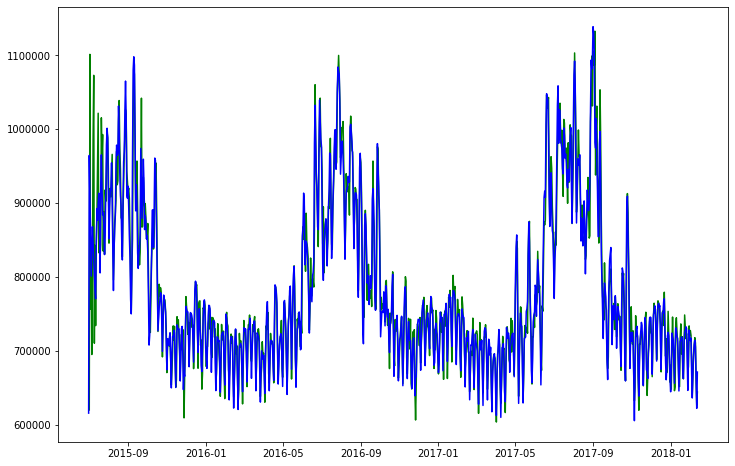

In [63]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(25000, 55000)

plt.plot(demand_hat3[1:], c='g')
plt.plot(X_train.index, X_train['day_demand'].values, c='b')

----

##### <a id='plot-SARI_xexof_fit_wide'>5C.2 SARIMAX With Extended Exogeneous Data - Fit Plot 3 Month </a>

----

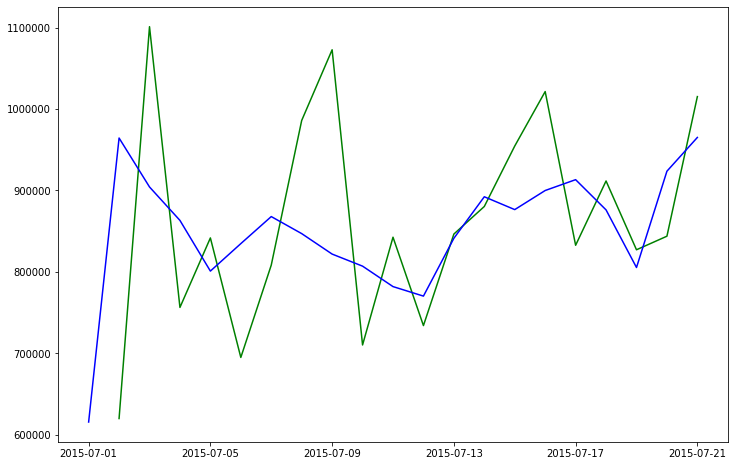

In [64]:
fig = plt.figure(figsize=[12, 8])

#plt.ylim(0, 55000)

plt.plot(demand_hat3[1:21], label='Prediction', c='g')
actual = X_train['day_demand'].values
plt.plot(X_train.index[:21], X_train['day_demand'].values[:21], c='b', label='Actual')

In [65]:
# Save the trained model
filename = 'SARIMAX_w_xexog_day.sav'
pickle.dump(model3, open(filename, 'wb'))

----
##### <a id='forecast-SARI_xexog'>5C.3 SARIMAX With Extended Exogeneous Data - Forecast  </a>
----

In [66]:
predict_steps = 7*4
predict3 = res3.get_forecast(predict_steps, 
                exog=X_walk1[best_exog_columns3].values[:predict_steps, :])
pred_ci3 = np.exp(predict3.conf_int(alpha=0.5))
pred_vals3 = np.exp(predict3.predicted_mean)

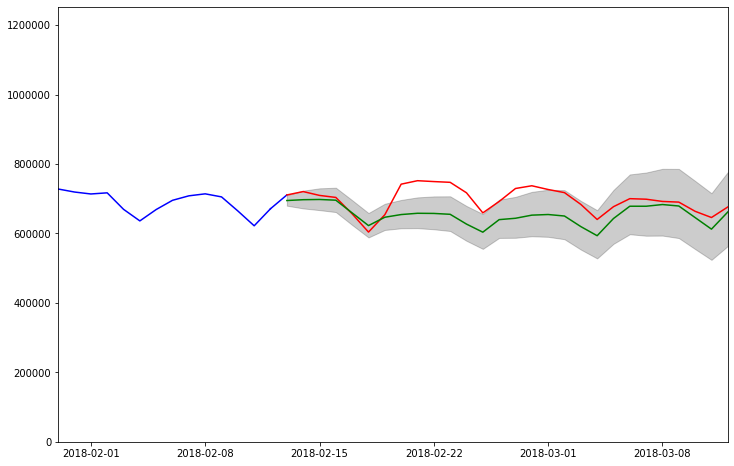

In [67]:
fig = plt.figure(figsize=[12, 8])

plt.ylim(0, 15000)
date_list = X_train.index

low_values = pred_ci3.iloc[:, 0].values
high_values = pred_ci3.iloc[:, 1].values
pred_times3 = pred_ci3.index

plt.xlim(min(date_list[int(-0.5*predict_steps):]), max(pred_times3))
plt.ylim(0, max([max(high_values), 1.1*max(max(X_train['day_demand']), max(X_walk1['day_demand']))]))

plt.plot(X_train.index[-2*predict_steps:], X_train['day_demand'].values[-2*predict_steps:], c='b')
plt.plot([X_train.index[-1], X_walk1['day_demand'].index[0]], \
          [X_train['day_demand'].values[-1], X_walk1['day_demand'].values[0]], c='b')
plt.plot(X_walk1.index, X_walk1['day_demand'].values, c='r')
plt.plot(pred_times3, pred_vals3.values, c='g')


plt.fill_between(pred_times3, low_values, high_values, color='k', alpha=0.2)

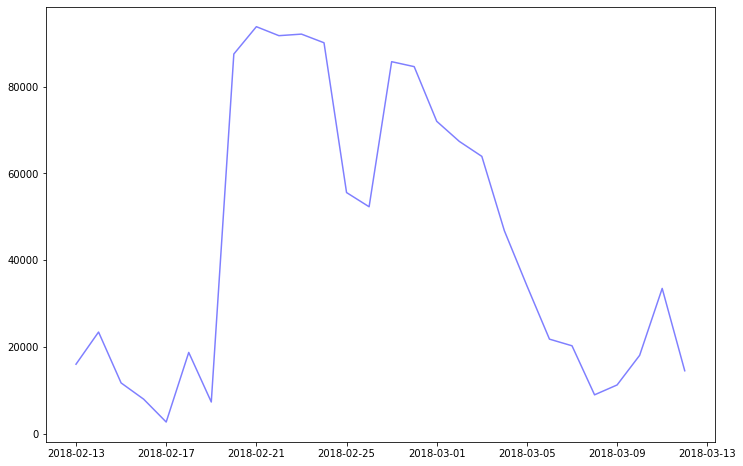

In [68]:
fig = plt.figure(figsize=[12, 8])
residuals3 = [abs(X_walk1['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
plt.plot(pred_times3, residuals3, c='b', alpha=0.5)
#plt.ylim(0, 10000)

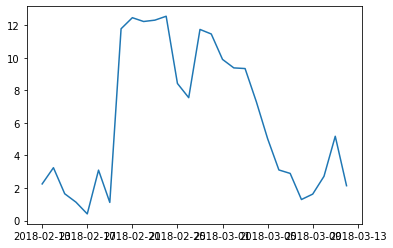

In [69]:
residuals = [abs(X_walk1['day_demand'].values[x] - pred_vals3.values[x]) for x in range(len(pred_vals3))]
percent_error = [residuals[x]/X_walk1['day_demand'].values[x]*100 for x in range(len(residuals))]
plt.plot(pred_times3, percent_error)
#plt.ylim(0, 7000)

In [70]:
mape3 = np.mean(percent_error[:21])
print(mape3)

7.356890583261067
